# [California Housing Data Analysis](https://www.kaggle.com/c/atividade-regressao-PMR3508)

[PMR3508](https://uspdigital.usp.br/jupiterweb/obterDisciplina?sgldis=PMR3508) - Machine Learning and Pattern Recognition

Professor Fabio Gagliardi Cozman

PMR3508-2020-83 - [Vitor Gratiere Torres](https://github.com/vitorgt/PMR3508)

This analysis consists in predicting the median sell value of a house given its region's location, number of rooms, median age, population, households and median income. My analysis take the following steps:

1. [Import data and python modules](#1.-Import-data-and-python-modules)
1. [Analysing data](#2.-Analysing-data)
1. [Regression](#3.-Regression)

# 1. Import data and python modules

In [1]:
import numpy as np
import pandas as pd

from sklearn import preprocessing, linear_model
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer

import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
cali = pd.read_csv(
    "atividade-regressao-PMR3508/train.csv", index_col=["Id"]
#     "../input/atividade-regressao-PMR3508/train.csv", index_col=["Id"]
)
caliTest = pd.read_csv(
    "atividade-regressao-PMR3508/test.csv", index_col=["Id"]
#     "../input/atividade-regressao-PMR3508/test.csv", index_col=["Id"]
)

print("Training data shape:", cali.shape)
print("Testing data shape:", caliTest.shape)

cali.sample(5)

Training data shape: (14448, 9)
Testing data shape: (6192, 8)


,longitude,latitude,median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
Id,,,,,,,,,
13953,-120.43,34.96,24,1799,470,1416,408,20673,136900
13377,-120.83,39.27,14,3338,608,1373,562,36700,160100
8895,-117.17,33.28,16,1921,312,862,280,51786,376800
1260,-117.80,33.74,33,2890,453,1300,452,65616,290200
6681,-122.22,37.81,52,2944,536,1034,521,53509,302100


In [3]:
cali.describe()

,longitude,latitude,median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,14448.000000,14448.000000,14448.000000,14448.000000,14448.000000,14448.000000,14448.000000,14448.000000,14448.000000
mean,-119.563050,35.625804,28.700028,2622.627284,535.628391,1413.978405,496.934109,38747.577450,207556.603267
std,2.008096,2.138690,12.587508,2145.423570,416.800426,1095.060629,376.873380,19091.513037,116441.436255
min,-124.350000,32.550000,1.000000,2.000000,2.000000,3.000000,2.000000,4999.000000,14999.000000
25%,-121.790000,33.930000,18.000000,1444.000000,295.000000,784.000000,279.000000,25596.500000,119300.000000
50%,-118.490000,34.250000,29.000000,2116.000000,432.000000,1160.000000,407.000000,35334.000000,179950.000000
75%,-118.000000,37.710000,37.000000,3131.250000,645.250000,1705.000000,602.000000,47500.000000,266100.000000
max,-114.470000,41.950000,52.000000,39320.000000,6445.000000,28566.000000,6082.000000,150001.000000,500001.000000


It is noticeable in ```describe()``` that every ```count``` is equal, so there is no ```NA```, let's verify:

In [4]:
print("Training dataset has missing data:")
print((cali.isna().any()) | (cali.isnull().any()))
print("\nTesting dataset has missing data:")
print((caliTest.isna().any()) | (caliTest.isnull().any()))

Training dataset has missing data:
longitude             False
latitude              False
median_age            False
total_rooms           False
total_bedrooms        False
population            False
households            False
median_income         False
median_house_value    False
dtype: bool

Testing dataset has missing data:
longitude         False
latitude          False
median_age        False
total_rooms       False
total_bedrooms    False
population        False
households        False
median_income     False
dtype: bool


Indeed, there is no missing data, which is great!

Now I want to create some new semantic variables:

In [5]:
def newVariables(data):
    data.loc[:, "mean_rooms_per_household"] = (
        data.loc[:, "total_rooms"] / data.loc[:, "households"]
    )
    data.loc[:, "mean_people_per_household"] = (
        data.loc[:, "population"] / data.loc[:, "households"]
    )
    data.loc[:, "bedrooms_per_room_ratio"] = (
        data.loc[:, "total_bedrooms"] / data.loc[:, "total_rooms"]
    )


newVariables(cali)
newVariables(caliTest)

In [6]:
def norm2(lon1, lat1, lon2, lat2):
    """Norm 2 distance between two coordinates, in radians"""
    lon1, lat1 = np.radians([lon1, lat1])
    lon2, lat2 = np.radians([lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    return np.sqrt(dlon ** 2 + dlat ** 2)


def haversine(lon1, lat1, lon2, lat2):
    """Spherical distance between two coordinates,
    in km (based on Earth's mean radius)
    """
    # source: https://www.movable-type.co.uk/scripts/latlong.html
    earthRadius = 6371
    lon1, lat1 = np.radians([lon1, lat1])
    lon2, lat2 = np.radians([lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = (
        np.sin(dlat / 2) ** 2
        + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    )
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return earthRadius * c


def citiesDistance(data, formula):
    lon = data.loc[:, "longitude"]
    lat = data.loc[:, "latitude"]

    data.loc[:, "dist_la"] = formula(lon, lat, -118.25, 34.05)
    data.loc[:, "dist_sd"] = formula(lon, lat, -117.1625, 32.715)
    data.loc[:, "dist_sj"] = formula(lon, lat, -121.9, 37.333333)
    data.loc[:, "dist_sf"] = formula(lon, lat, -122.416389, 37.7775)

    data.loc[:, "dist_big_city"] = np.min(
        data.loc[:, ["dist_la", "dist_sd", "dist_sj", "dist_sf"]],
        axis=1,
    )
    
    data.loc[data.loc[:, "dist_big_city"] == 0, "dist_big_city"] = 0.1

    data.drop(
        ["dist_la", "dist_sd", "dist_sj", "dist_sf"],
        axis=1,
        inplace=True,
    )


citiesDistance(cali, haversine)
citiesDistance(caliTest, haversine)

# 2. Analysing data

array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'median_age'}>,
        <AxesSubplot:title={'center':'total_rooms'}>],
       [<AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>,
        <AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>],
       [<AxesSubplot:title={'center':'median_house_value'}>,
        <AxesSubplot:title={'center':'mean_rooms_per_household'}>,
        <AxesSubplot:title={'center':'mean_people_per_household'}>,
        <AxesSubplot:title={'center':'bedrooms_per_room_ratio'}>],
       [<AxesSubplot:title={'center':'dist_big_city'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

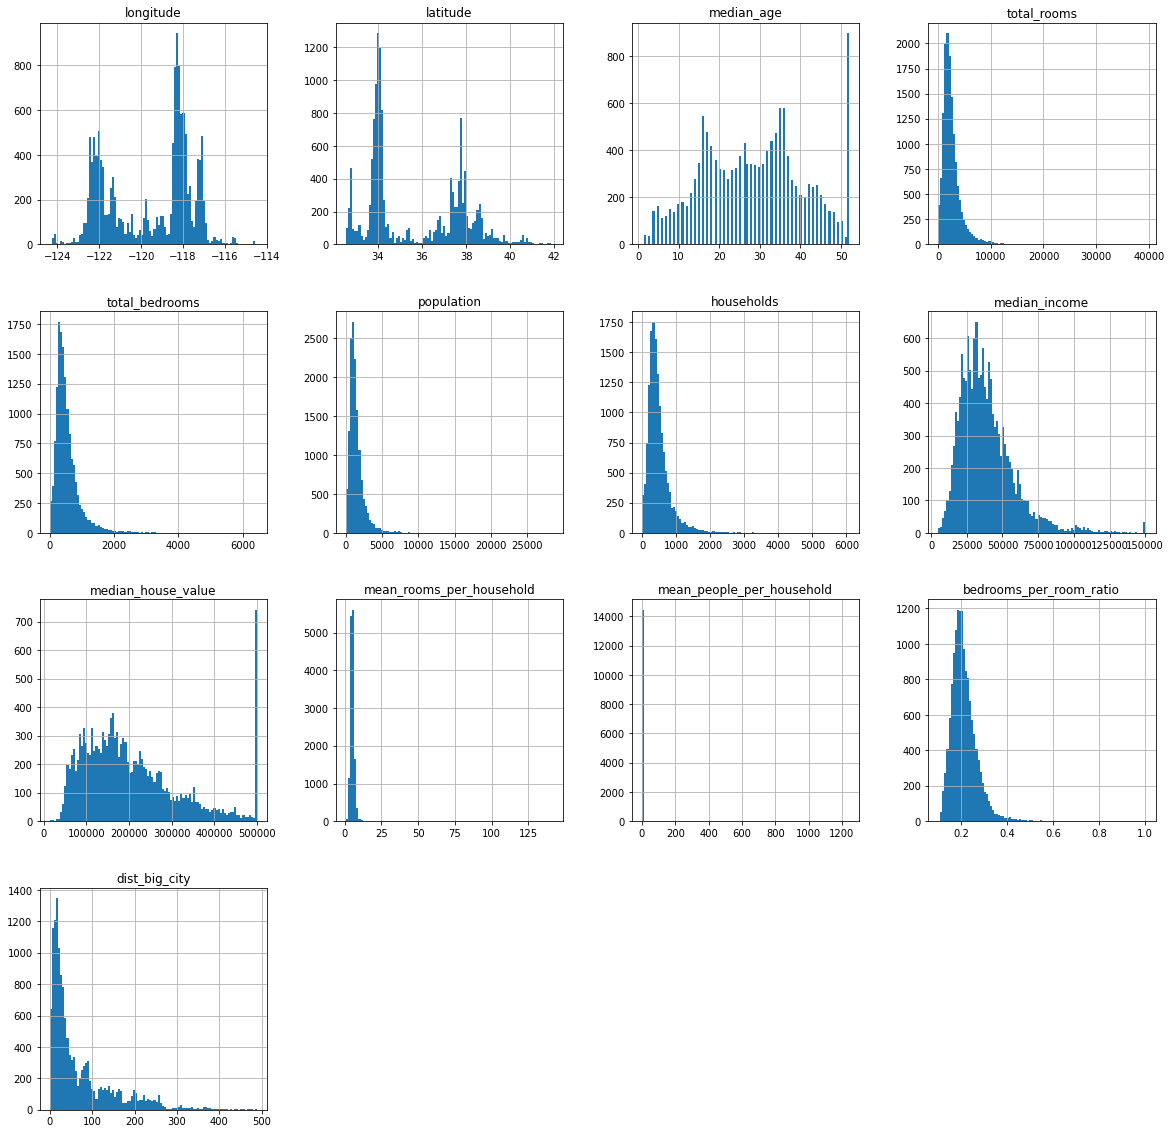

In [7]:
cali.hist(bins=100, figsize=(20, 20))

In [8]:
mapPlot = px.scatter_mapbox(
    cali,
    lon="longitude",
    lat="latitude",
    size="population",
    size_max=15,
    color="median_house_value",
    zoom=4.3,
    center=dict(
        lon=(cali.longitude.max() - cali.longitude.min()) / 2.0
        + cali.longitude.min(),
        lat=(cali.latitude.max() - cali.latitude.min()) / 2.0
        + cali.latitude.min(),
    ),
    mapbox_style="carto-darkmatter",
)

mapPlot.show(renderer="kaggle")

In [9]:
distval = px.scatter(
    data_frame=cali,
    x="dist_big_city",
    y="median_house_value",
    color="median_income",
    marginal_x="box",
    marginal_y="box",
    trendline="lowess",
)
distval.show(renderer="kaggle")

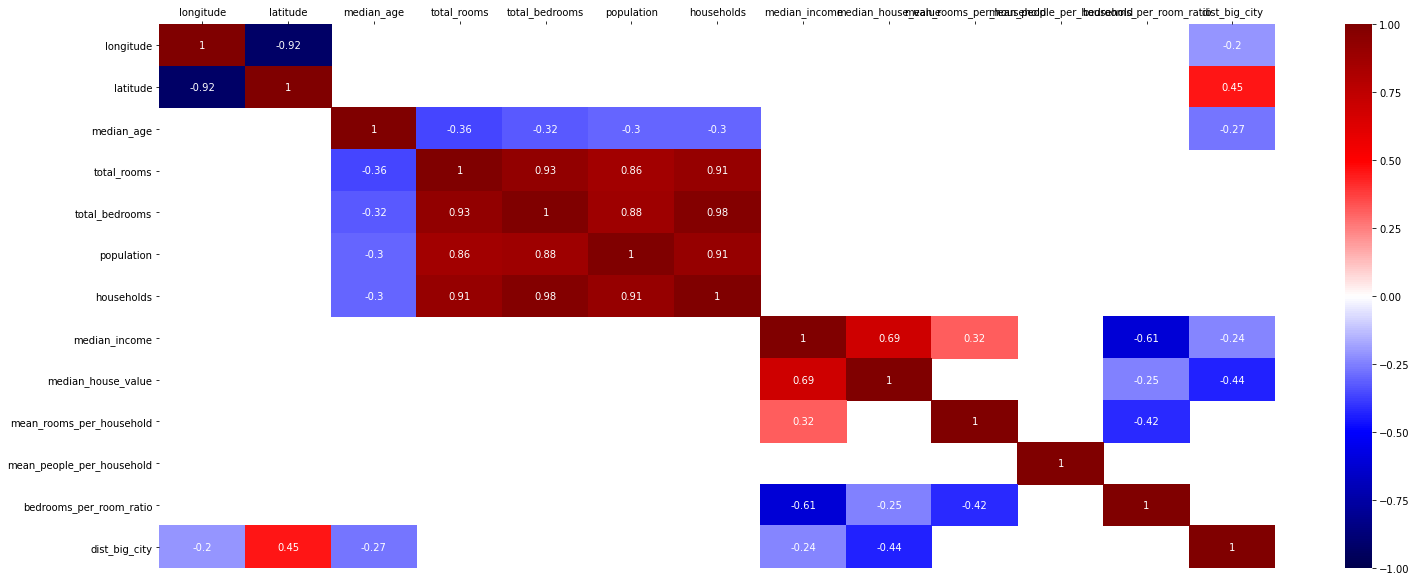

In [10]:
corrmat = cali.corr()
plt.figure(figsize=(25, 10))
threshold = 0.2
sns.heatmap(
    corrmat[abs(corrmat) > threshold],
    vmax=1.0,
    vmin=-1.0,
    annot=True,
    cmap="seismic",
).xaxis.tick_top()

Given that correlations lesser than $|0.2|$ are considered weak, from this correlation matrix, it is possible to imply some semantic information:

1. ```longitude``` and ```latitude``` are strongly inversely correlated because, if we look at the map of California, we can see that it is a decreasing diagonal;

1. ```total_rooms```, ```total_bedrooms```, ```population``` and ```households``` are strongly positively correlated because in an area with more population there will be more rooms, more bedrooms and more houses, in an area with more houses there will be more people, and so on;

1. the greater the ```median_age```, the older the region, and the less houses it has, meaning a slightly decrease in the the ```total_rooms```, ```total_bedrooms```, ```population``` and ```households``` at that region;

1. ```median_house_value```:

    1. correlation to ```median_income``` translates to "the more money someone has, the more expensive their house is";

    1. correlation to ```dist_big_city``` translates to "big citites houses are more expensive";

    1. yet ```median_house_value``` (the target variable) mostly has weak correlations implying that regression might not be suitable, yielding poor predictions.

# 3. Regression

First I need to define a scorer to evaluate the cross validation.

In [11]:
def RMSLE(y_in, y_out):
    """RMSLE score by Rodrigo Gebara Reis."""
    return np.sqrt(
        np.mean(
            (np.log(np.abs(y_out) + 1) - np.log(np.abs(y_in) + 1)) ** 2
        )
    )


RMSLE_scorer = make_scorer(RMSLE, greater_is_better=False)

Now I'll create dictionaries to call functions and store its data.

This regression will be based on 5 scalers and 4 regressors.

* Scalers:

    1. ```DoNotScale```: In this approach data won't be scaled;
    
    1. [```MinMaxScaler```](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html): Scale each feature to fit the [0, 1] interval;
    
    1. [```StandardScaler```](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html): Standardize features by removing the mean and scaling to unit variance;
    
    1. [```BoxCox```](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html): Make data more Gaussian-like;
    
    1. [```QuantileTransformer```](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html): Transform features using quantiles information.



* Regressors:

    1. [```Ridge```](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html): Linear least squares with l2 regularization;

    1. [```Lasso```](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html): Linear Model trained with L1 prior as regularizer (aka the Lasso);

    1. [```LinearRegression```](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html): Ordinary least squares Linear Regression;

    1. [```Knn```](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html): Regression based on k-nearest neighbors.

In [12]:
def DoNotScale(data):
    return data

scalers = {
    "NotScaled": {
        "f": DoNotScale,
        "Xtrain": None,
        "Xtest": None,
    },
    "MinMaxScaler": {
        "f": preprocessing.MinMaxScaler().fit_transform,
        "Xtrain": None,
        "Xtest": None,
    },
    "StandardScaler": {
        "f": preprocessing.StandardScaler().fit_transform,
        "Xtrain": None,
        "Xtest": None,
    },
    "BoxCox": {
        "f": preprocessing.PowerTransformer(
            method="box-cox", standardize=False
        ).fit_transform,
        "Xtrain": None,
        "Xtest": None,
    },
    "QuantileTransformer": {
        "f": preprocessing.QuantileTransformer(
            output_distribution="normal", random_state=0
        ).fit_transform,
        "Xtrain": None,
        "Xtest": None,
    },
}

In [13]:
models_wo_params = {
    "LinearRegression": linear_model.LinearRegression(),
}
models_w_params = {
    "Ridge": {
        "f": linear_model.Ridge,
        "k_lower": 1,
        "k_upper": 1001,
        "k_step": 0.01,
    },
    "Lasso": {
        "f": linear_model.Lasso,
        "k_lower": 1,
        "k_upper": 401,
        "k_step": 10,
    },
    "Knn": {
        "f": KNeighborsRegressor,
        "k_lower": 1,
        "k_upper": 101,
        "k_step": 1,
    },
}

Structure to keep best regression info.

In [14]:
min_error = {"val": np.inf, "scaler": None, "regressor": None, "param": None}

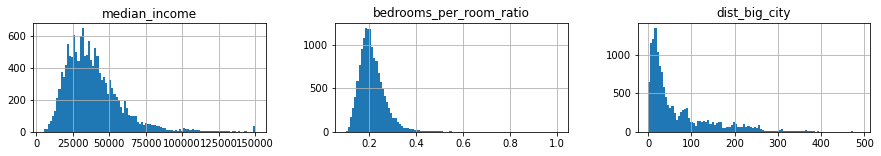

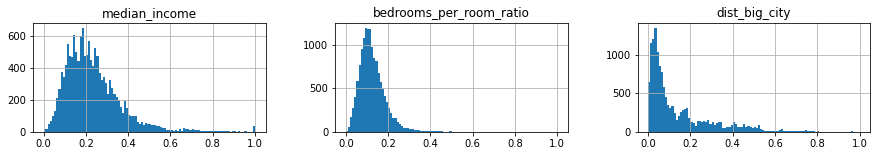

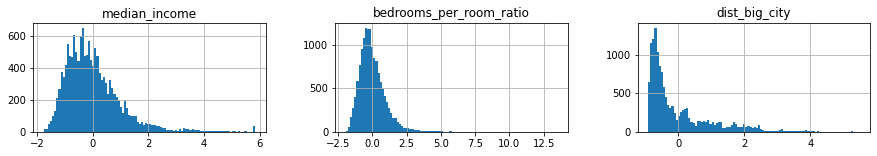

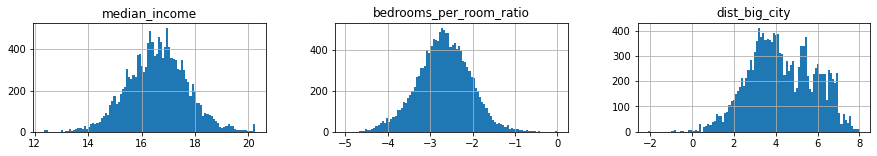

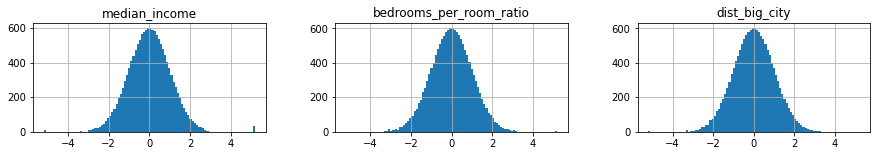

In [15]:
for k, scaler in scalers.items():

    Xtrain = cali.loc[
        :, ["median_income", "bedrooms_per_room_ratio", "dist_big_city"]
    ].copy()

    Xtest = caliTest.loc[
        :, ["median_income", "bedrooms_per_room_ratio", "dist_big_city"]
    ].copy()

    Xtrain.loc[:, :] = scaler["f"](Xtrain)
    Xtest.loc[:, :] = scaler["f"](Xtest)
    scalers[k]["Xtrain"] = Xtrain
    scalers[k]["Xtest"] = Xtest
    Xtrain.hist(bins=100, figsize=(15, 2), layout=(1, 3))


Ytrain = cali.loc[:, "median_house_value"].copy()
Ytest = Xtest.drop(
    ["median_income", "bedrooms_per_room_ratio", "dist_big_city"],
    axis=1,
)

Although they might look alike, note that there are significant changes at each axis

In [16]:
for reg_name, reg in models_wo_params.items():

    for scaler_name, scaler in scalers.items():

        error = np.mean(
            np.abs(
                cross_val_score(
                    reg,
                    scaler["Xtrain"],
                    Ytrain,
                    scoring=RMSLE_scorer,
                    cv=10,
                )
            )
        )

        if error < min_error["val"]:
            min_error["val"] = error
            min_error["scaler"] = scaler_name
            min_error["regressor"] = reg_name
            min_error["param"] = None

        print(reg_name, scaler_name, "done")

print(min_error)

LinearRegression NotScaled done
LinearRegression MinMaxScaler done
LinearRegression StandardScaler done
LinearRegression BoxCox done
LinearRegression QuantileTransformer done
{'val': 0.40415956073797804, 'scaler': 'MinMaxScaler', 'regressor': 'LinearRegression', 'param': None}


In [17]:
fig = go.Figure()

for reg_name, hiperreg in models_w_params.items():

    k_lower = hiperreg["k_lower"]
    k_upper = hiperreg["k_upper"]
    k_step = hiperreg["k_step"]

    for scaler_name, scaler in scalers.items():

        print(reg_name, scaler_name, "started")

        k_error = []

        for k in range(k_lower, k_upper):

            reg = hiperreg["f"](k * k_step)

            k_error.append(
                np.mean(
                    np.abs(
                        cross_val_score(
                            reg,
                            scaler["Xtrain"],
                            Ytrain,
                            scoring=RMSLE_scorer,
                            cv=10,
                        )
                    )
                )
            )

        min_e_k = k_error.index(min(k_error))
        min_e = k_error[min_e_k]
        min_e_k = (min_e_k + 1) * k_step

        if min_e < min_error["val"]:
            min_error["val"] = min_e
            min_error["scaler"] = scaler_name
            min_error["regressor"] = reg_name
            min_error["param"] = min_e_k

        fig.add_trace(
            go.Scatter(
                x=list(range(k_lower, k_upper)),
                y=k_error,
                mode="lines",
                name=str(reg_name+" "+scaler_name),
            )
        )

        print(reg_name, scaler_name, "done")
        print("^ k", min_e_k, "error", min_e)
        print(min_error)

fig.show(renderer="kaggle")

Ridge NotScaled started
Ridge NotScaled done
^ k 0.01 error 0.4041599690505717
{'val': 0.40415956073797804, 'scaler': 'MinMaxScaler', 'regressor': 'LinearRegression', 'param': None}
Ridge MinMaxScaler started
Ridge MinMaxScaler done
^ k 1.08 error 0.40377324667473874
{'val': 0.40377324667473874, 'scaler': 'MinMaxScaler', 'regressor': 'Ridge', 'param': 1.08}
Ridge StandardScaler started
Ridge StandardScaler done
^ k 10.0 error 0.4039621500524387
{'val': 0.40377324667473874, 'scaler': 'MinMaxScaler', 'regressor': 'Ridge', 'param': 1.08}
Ridge BoxCox started
Ridge BoxCox done
^ k 10.0 error 0.47103458596360903
{'val': 0.40377324667473874, 'scaler': 'MinMaxScaler', 'regressor': 'Ridge', 'param': 1.08}
Ridge QuantileTransformer started
Ridge QuantileTransformer done
^ k 10.0 error 0.47071779657947854
{'val': 0.40377324667473874, 'scaler': 'MinMaxScaler', 'regressor': 'Ridge', 'param': 1.08}
Lasso NotScaled started
Lasso NotScaled done
^ k 10 error 0.4042310185135703
{'val': 0.40377324667473

In [18]:
print(min_error)
my_choice = {
    "scaler": "MinMaxScaler",
    "regressor": "Lasso",
    "param": 1535,
}
print(my_choice)

reg = models_w_params[min_error["regressor"]]["f"](min_error["param"])
reg.fit(scalers[min_error["scaler"]]["Xtrain"], Ytrain)

Ytest.loc[:, "median_house_value_knn"] = np.abs(
    reg.predict(scalers[min_error["scaler"]]["Xtest"])
)

reg = models_w_params[my_choice["regressor"]]["f"](my_choice["param"])
reg.fit(scalers[my_choice["scaler"]]["Xtrain"], Ytrain)

Ytest.loc[:, "median_house_value"] = np.abs(
    reg.predict(scalers[my_choice["scaler"]]["Xtest"])
)

{'val': 0.33533749340446034, 'scaler': 'BoxCox', 'regressor': 'Knn', 'param': 71}
{'scaler': 'MinMaxScaler', 'regressor': 'Lasso', 'param': 1535}


In [20]:
mapPlot = px.scatter_mapbox(
    caliTest,
    lon="longitude",
    lat="latitude",
    size="population",
    size_max=15,
    color=Ytest.loc[:, "median_house_value_knn"],
    zoom=4.3,
    center=dict(
        lon=(caliTest.longitude.max() - caliTest.longitude.min()) / 2.0
        + caliTest.longitude.min(),
        lat=(caliTest.latitude.max() - caliTest.latitude.min()) / 2.0
        + caliTest.latitude.min(),
    ),
    mapbox_style="carto-darkmatter",
    title=str(
        min_error["regressor"]
        + " regression predition with "
        + min_error["scaler"]
        + " with k="
        + str(min_error["param"])
    ),
)

mapPlot.show(renderer="kaggle")

In [21]:
mapPlot = px.scatter_mapbox(
    caliTest,
    lon="longitude",
    lat="latitude",
    size="population",
    size_max=15,
    color=Ytest.loc[:, "median_house_value"],
    zoom=4.3,
    center=dict(
        lon=(caliTest.longitude.max() - caliTest.longitude.min()) / 2.0
        + caliTest.longitude.min(),
        lat=(caliTest.latitude.max() - caliTest.latitude.min()) / 2.0
        + caliTest.latitude.min(),
    ),
    mapbox_style="carto-darkmatter",
    title=str(
        my_choice["regressor"]
        + " regression predition with "
        + my_choice["scaler"]
        + " with alpha="
        + str(min_error["param"])
    ),
)

mapPlot.show(renderer="kaggle")

I've chosen ```Lasso``` regressor with ```alpha=1535``` because every ```Knn``` got too overfitted, yelding lots of yellow spots.

In [22]:
Ytest.drop("median_house_value_knn", axis=1, inplace=True)
Ytest.to_csv("submission.csv", index=True, index_label="Id")
Ytest

,median_house_value
Id,
8609,345863.800974
14610,205645.867811
1557,137140.392387
12875,155729.424525
17821,195910.025003
...,...
2245,165362.757606
10825,229811.741540
9546,235517.503272
